# Demo - Bias in Words Embedding

In this demo, we are going to work with three complete words embeddings at once in the notebook, which will take a lot of memory (~20GB). Therefore, if your machine doesn't have plenty of RAM, it is possible to perform the analysis either separately for each words embeddings or only on one.

## Imports

In [1]:
import matplotlib.pylab as plt

from gensim import downloader
from gensim.models import KeyedVectors

## Download and Load Words Embeddings

### [Google's Word2Vec](https://code.google.com/archive/p/word2vec/) - Google News dataset (100B tokens, 3M vocab, cased, 300d vectors, 1.65GB download)

In [2]:
w2v_path = downloader.load('word2vec-google-news-300', return_path=True)
print(w2v_path)

w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


### [Facebook's fastText](https://fasttext.cc/)

In [3]:
fasttext_path = downloader.load('fasttext-wiki-news-subwords-300', return_path=True)
print(fasttext_path)

fasttext_model = KeyedVectors.load_word2vec_format(fasttext_path)

[==================================================] 100.0% 958.5/958.4MB downloaded
/root/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz


### [Stanford's Glove](https://nlp.stanford.edu/projects/glove/) - Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download)

In [4]:
import os
import gzip
import shutil
from urllib.request import urlretrieve
from zipfile import ZipFile
from pathlib import Path

from gensim.scripts.glove2word2vec import glove2word2vec

GLOVE_PATH = None

if GLOVE_PATH is None:
    print('Downloading...')
    glove_zip_path, _ = urlretrieve('http://nlp.stanford.edu/data/glove.840B.300d.zip')
    glob_dir_path = Path(glove_zip_path).parent
    print('Unzipping...')
    with ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall(str(glob_dir_path))
    print('Converting to Word2Vec format...')
    glove2word2vec(glob_dir_path / 'glove.840B.300d.txt',
                   glob_dir_path / 'glove.840B.300d.w2v.txt')

print('Loading...')    
glove_model = KeyedVectors.load_word2vec_format(glob_dir_path / 'glove.840B.300d.w2v.txt')

Downloading...
Unzipping...
Converting to Word2Vec format...
Loading...


## Bolukbasi Bias Measure and Debiasing

Based on:
Bolukbasi Tolga, Kai-Wei Chang, James Y. Zou, Venkatesh Saligrama, and Adam T. Kalai. [Man is to computer programmer as woman is to homemaker? debiasing word embeddings](https://arxiv.org/abs/1607.06520). NIPS 2016.

In [5]:
from ethically.we import GenderBiasWE

### Create a gender bias words embedding object (`GenderBiasWE`)

In [6]:
w2v_gender_bias_we = GenderBiasWE(w2v_model, only_lower=False, verbose=True)

Identify direction using pca method...
  Principal Component    Explained Variance Ratio
---------------------  --------------------------
                    1                  0.605292
                    2                  0.127255
                    3                  0.099281
                    4                  0.0483466
                    5                  0.0406355
                    6                  0.0252729
                    7                  0.0232224
                    8                  0.0123879
                    9                  0.00996098
                   10                  0.00834613


### Evaluate the Words Embedding

In [7]:
w2v_biased_evaluation = w2v_gender_bias_we.evaluate_words_embedding()

#### Word pairs

In [8]:
w2v_biased_evaluation[0]

,pearson_r,pearson_pvalue,spearman_r,spearman_pvalue,ratio_unkonwn_words
MEN,0.682,0.00,0.699,0.00,0.000
Mturk,0.632,0.00,0.656,0.00,0.000
RG65,0.801,0.03,0.685,0.09,0.000
RW,0.523,0.00,0.553,0.00,33.727
SimLex999,0.447,0.00,0.436,0.00,0.100
TR9856,0.661,0.00,0.662,0.00,85.430
WS353,0.624,0.00,0.659,0.00,0.000


#### Analogies

In [9]:
w2v_biased_evaluation[1]

,score
Google,0.740
MSR-syntax,0.736


### Calculate direct gender bias

In [10]:
w2v_gender_bias_we.calc_direct_bias()

0.0730790424948194

### Plot the projection of the most extreme professions on the gender direction

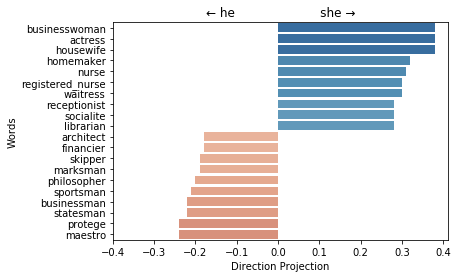

In [11]:
w2v_gender_bias_we.plot_projection_scores();

### Plot the distribution of projections of the word groups that are being used for the auditing and adjusting the model

1. **profession_name** - List of profession names, neutral and gender spcific.
2. **neutral_profession_name** - List of only neutral profession names.
3. **specific_seed** - Seed list of gender specific words.
4. **specific_full** - List of the learned specifc gender over all the vocabulary.
5. **specific_full_with_definitional** -  **specific_full** with the words that were used to define the gender direction.
6. **neutral_words** - List of all the words in the vocabulary that are not part of **specific_full_with_definitional**.

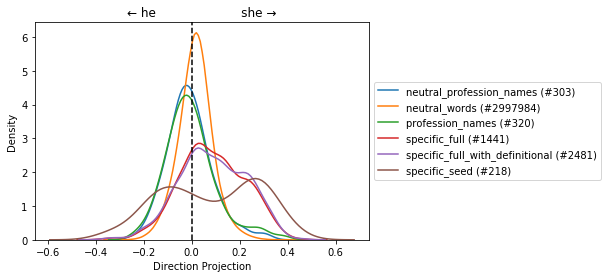

In [12]:
w2v_gender_bias_we.plot_dist_projections_on_direction();

### Generate analogies along the gender direction
Skipping the first 50, because they are mostly appropriate gender analogies

In [13]:
w2v_gender_bias_we.generate_analogies(150)[50:]

,x,y,distance,score
50,diva,superstar,0.912041,0.478637
51,Kylie,Robbie,0.965910,0.469355
52,Ana,Sergio,0.932191,0.459715
53,Lady_Vols,Vols,0.667961,0.455486
54,Gloria,Ernie,0.987297,0.455313
55,Susie,Johnny,0.982425,0.451297
56,Veronica,Dominic,0.991988,0.450322
57,Mother_Day,Father_Day,0.696741,0.450317
58,waitress,waiter,0.695489,0.449741
59,LPGA_Tour,PGA_Tour,0.654526,0.445583


### Generate the Indirect Gender Bias in the direction `softball`-`football`

In [14]:
w2v_gender_bias_we.generate_closest_words_indirect_bias('softball', 'football')

projection  indirect_bias
end      word                                       
softball bookkeeper          0.195044       0.201158
         registered_nurse    0.176933       0.287150
         infielder           0.171764      -0.054049
         waitress            0.163246       0.317842
         receptionist        0.159252       0.672343
football philosopher        -0.148482       0.220857
         pundit             -0.170339       0.101227
         businessman        -0.174114       0.170078
         maestro            -0.175094       0.415804
         footballer         -0.275374       0.015366

### Perform hard-debiasing

The table shows the details of the equalize step on the equality sets.

In [15]:
w2v_gender_debias_we = w2v_gender_bias_we.debias('hard', inplace=False)

  0%|          | 7/2997984 [00:00<13:40:24, 60.90it/s]

Neutralize...


100%|██████████| 2997984/2997984 [01:52<00:00, 26746.02it/s]


Equalize...
Equalize Words Data (all equal for 1-dim bias space (direction):
                   equalized_projected_scalar    projected_scalar    scaling
---------------  ----------------------------  ------------------  ---------
(0, 'female')                        0.336739           0.282941    0.336739
(0, 'male')                         -0.336739           0.083992    0.336739
(1, 'Mary')                          0.488704           0.301974    0.488704
(1, 'John')                         -0.488704          -0.251126    0.488704
(2, 'she')                           0.443113           0.469059    0.443113
(2, 'he')                           -0.443113          -0.362353    0.443113
(3, 'DAUGHTER')                      0.521962           0.171916    0.521962
(3, 'SON')                          -0.521962           0.0122388   0.521962
(4, 'Daughter')                      0.469635           0.22278     0.469635
(4, 'Son')                          -0.469635          -0.16829     0.469635

## Now our model is gender debiased, let's check what changed...

### Evaluate the debiased model


The evaluation of the words embedding did not change so much because of the debiasing:

In [16]:
w2v_debiased_evaluation = w2v_gender_debias_we.evaluate_words_embedding()

In [17]:
w2v_debiased_evaluation[0]

,pearson_r,pearson_pvalue,spearman_r,spearman_pvalue,ratio_unkonwn_words
MEN,0.680,0.000,0.698,0.00,0.000
Mturk,0.633,0.000,0.656,0.00,0.000
RG65,0.800,0.031,0.685,0.09,0.000
RW,0.522,0.000,0.552,0.00,33.727
SimLex999,0.450,0.000,0.438,0.00,0.100
TR9856,0.661,0.000,0.662,0.00,85.430
WS353,0.623,0.000,0.657,0.00,0.000


In [18]:
w2v_debiased_evaluation[1]

,score
Google,0.737
MSR-syntax,0.736


### Calculate direct gender bias

In [19]:
w2v_gender_debias_we.calc_direct_bias()

1.7964246601064155e-09

The words embedding is not biased any more (in the professions sense).

### Plot the projection of the most extreme professions on the gender direction
Note that (almost) all of the non-zero projection words are gender specific.

The word *teenager* have a projection on the gender direction because it was learned mistakenly as a gender-specific word by the linear SVM, and thus it was not neutralized in the debias processes.

The words provost, serviceman and librarian have zero projection on the gender direction.

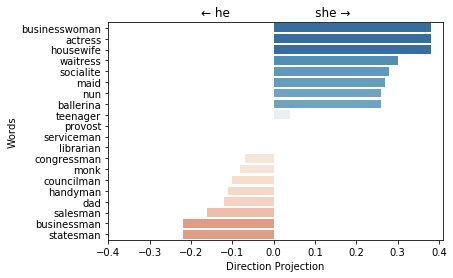

In [20]:
w2v_gender_debias_we.plot_projection_scores();

### Generate analogies along the gender direction

In [21]:
w2v_gender_debias_we.generate_analogies(150)[50:]

,x,y,distance,score
50,estrogen,hormone,0.696338,3.415194e-01
51,brides,couples,0.972528,3.321108e-01
52,breasts,penis,0.831993,3.135472e-01
53,compatriots,countrymen,0.668135,2.980544e-01
54,Moms,Kids,0.956169,2.873899e-01
55,Mothers,Families,0.992906,2.803815e-01
56,really,guys,0.904382,2.780661e-01
57,maid,prostitute,0.996605,2.730137e-01
58,entrepreneur,businessman,0.812313,2.690392e-01
59,menopause,osteoporosis,0.916623,2.671666e-01


### Generate the Indirect Gender Bias in the direction `softball`-`football`

In [22]:
w2v_gender_debias_we.generate_closest_words_indirect_bias('softball', 'football')

projection  indirect_bias
end      word                                      
softball infielder          0.149894   1.008288e-07
         major_leaguer      0.113700   5.297945e-09
         bookkeeper         0.104209   3.627948e-08
         patrolman          0.092638   1.222811e-07
         investigator       0.081746  -1.263093e-09
football midfielder        -0.153175   2.186535e-08
         lecturer          -0.153629   1.659876e-08
         vice_chancellor   -0.159645   1.804495e-07
         cleric            -0.166934  -3.282093e-08
         footballer        -0.325018   4.989304e-08

### Now Let's Try with fastText

In [23]:
fasttext_gender_bias_we = GenderBiasWE(fasttext_model, only_lower=False, verbose=True)

Identify direction using pca method...
  Principal Component    Explained Variance Ratio
---------------------  --------------------------
                    1                   0.531331
                    2                   0.18376
                    3                   0.089777
                    4                   0.0517856
                    5                   0.0407739
                    6                   0.0328988
                    7                   0.0223339
                    8                   0.0193495
                    9                   0.0143259
                   10                   0.0136648


### We can compare the projections of neutral profession names on the gender direction for the two original words embeddings

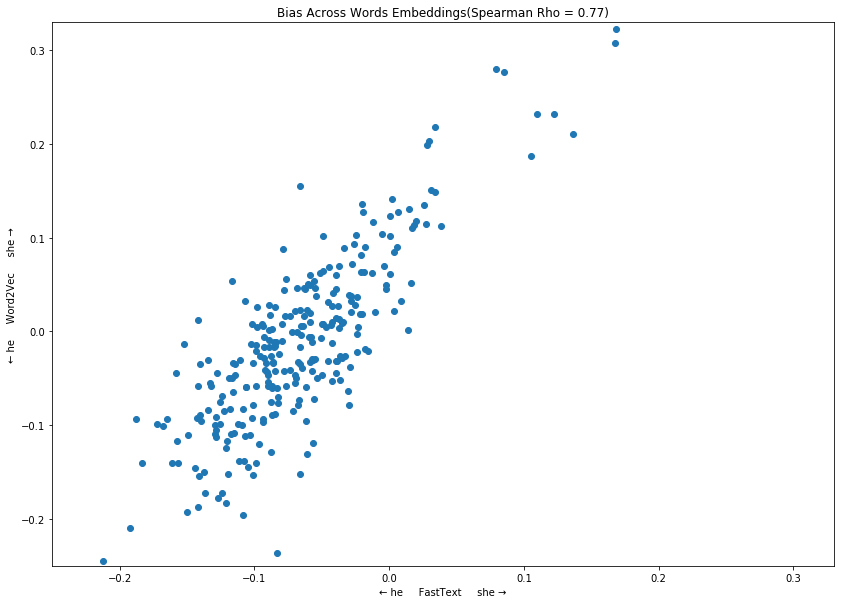

In [24]:
f, ax = plt.subplots(1, figsize=(14, 10))
GenderBiasWE.plot_bias_across_words_embeddings({'Word2Vec': w2v_gender_bias_we,
                                                'FastText': fasttext_gender_bias_we},
                                               ax=ax)

### And now let's perform the same steps for FastText

In [25]:
fasttext_biased_evaluation = fasttext_gender_bias_we.evaluate_words_embedding()

In [26]:
fasttext_biased_evaluation[0]

,pearson_r,pearson_pvalue,spearman_r,spearman_pvalue,ratio_unkonwn_words
MEN,0.669,0.000,0.673,0.000,0.000
Mturk,0.676,0.000,0.682,0.000,0.000
RG65,0.766,0.044,0.667,0.102,0.000
RW,0.546,0.000,0.546,0.000,16.519
SimLex999,0.432,0.000,0.418,0.000,0.100
TR9856,0.648,0.000,0.626,0.000,85.217
WS353,0.606,0.000,0.596,0.000,0.000


In [27]:
fasttext_biased_evaluation[1]

,score
Google,0.883
MSR-syntax,0.917


In [28]:
fasttext_gender_bias_we.calc_direct_bias()

0.07633256240142092

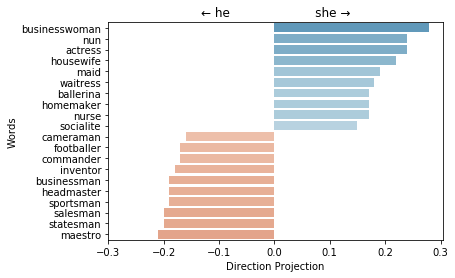

In [29]:
fasttext_gender_bias_we.plot_projection_scores();

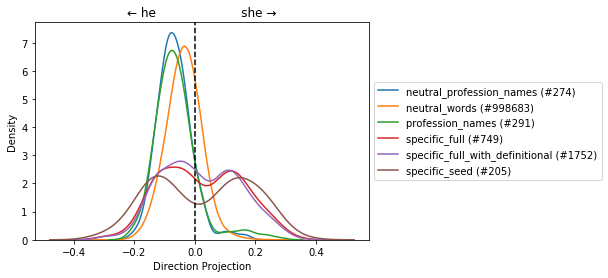

In [30]:
fasttext_gender_bias_we.plot_dist_projections_on_direction();

In [31]:
fasttext_gender_bias_we.generate_analogies(150)[100:]

,x,y,distance,score
100,female,male,0.564742,0.352283
101,singer,frontman,0.893373,0.346936
102,Volleyball,Football,0.938328,0.344304
103,feminist,liberal,0.997903,0.341058
104,kids,guys,0.946709,0.340327
105,estrogen,testosterone,0.796327,0.335635
106,adorable,goofy,0.952828,0.331766
107,feisty,combative,0.935207,0.326646
108,skirts,shorts,0.953106,0.326539
109,blonde,blond,0.529961,0.326442


In [32]:
fasttext_gender_bias_we.generate_closest_words_indirect_bias('softball', 'football')

projection  indirect_bias
end      word                                       
softball bookkeeper          0.195044       0.201158
         registered_nurse    0.176933       0.287150
         infielder           0.171764      -0.054049
         waitress            0.163246       0.317842
         receptionist        0.159252       0.672343
football philosopher        -0.148482       0.220857
         pundit             -0.170339       0.101227
         businessman        -0.174114       0.170078
         maestro            -0.175094       0.415804
         footballer         -0.275374       0.015366

In [33]:
fasttext_gender_bias_we.debias('hard')

  0%|          | 2209/998683 [00:00<00:45, 22086.91it/s]

Neutralize...


100%|██████████| 998683/998683 [00:39<00:00, 25177.19it/s]


Equalize...
Equalize Words Data (all equal for 1-dim bias space (direction):
                   equalized_projected_scalar    projected_scalar    scaling
---------------  ----------------------------  ------------------  ---------
(0, 'female')                        0.22163           0.245028     0.22163
(0, 'male')                         -0.22163           0.0909211    0.22163
(1, 'Mary')                          0.344783          0.185954     0.344783
(1, 'John')                         -0.344783         -0.226975     0.344783
(2, 'she')                           0.327879          0.272553     0.327879
(2, 'he')                           -0.327879         -0.314674     0.327879
(3, 'DAUGHTER')                      0.435387          0.11358      0.435387
(3, 'SON')                          -0.435387         -0.0219735    0.435387
(4, 'Daughter')                      0.387263          0.12953      0.387263
(4, 'Son')                          -0.387263         -0.164091     0.387263
(

In [34]:
fasttext_debiased_evaluation = fasttext_gender_bias_we.evaluate_words_embedding()

In [35]:
fasttext_debiased_evaluation[0]

,pearson_r,pearson_pvalue,spearman_r,spearman_pvalue,ratio_unkonwn_words
MEN,0.669,0.000,0.673,0.000,0.000
Mturk,0.677,0.000,0.682,0.000,0.000
RG65,0.767,0.044,0.667,0.102,0.000
RW,0.545,0.000,0.546,0.000,16.519
SimLex999,0.433,0.000,0.419,0.000,0.100
TR9856,0.647,0.000,0.625,0.000,85.217
WS353,0.609,0.000,0.598,0.000,0.000


In [36]:
fasttext_debiased_evaluation[1]

,score
Google,0.882
MSR-syntax,0.916


In [37]:
fasttext_gender_bias_we.calc_direct_bias()

1.4306556948502593e-09

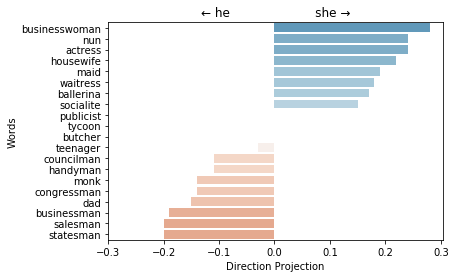

In [38]:
fasttext_gender_bias_we.plot_projection_scores();

In [39]:
fasttext_gender_bias_we.generate_analogies(150)[100:]

,x,y,distance,score
100,400,600,0.259647,2.549569e-08
101,1972,1973,0.195663,2.507729e-08
102,1843,1837,0.316132,2.498151e-08
103,6,5,0.136156,2.469707e-08
104,1923,1921,0.247878,2.438606e-08
105,1894,1884,0.314060,2.358365e-08
106,1878,1872,0.308520,2.286716e-08
107,1906,1910,0.280573,2.217063e-08
108,vector,vectors,0.486982,2.211400e-08
109,138,137,0.346574,2.189448e-08


In [40]:
fasttext_gender_bias_we.generate_closest_words_indirect_bias('softball', 'football')

projection  indirect_bias
end      word                                 
softball infielder     0.186223   4.205870e-08
         alderman      0.100549   7.837655e-08
         handyman      0.066572  -6.646021e-03
         mediator      0.060695   1.667881e-07
         ranger        0.059893   1.444559e-07
football coach        -0.185766   5.122636e-08
         sportsman    -0.204266   1.253264e-07
         goalkeeper   -0.234506   7.194591e-08
         midfielder   -0.236263   1.018931e-08
         footballer   -0.385277   1.098612e-07

### Can we identify race bias? (Exploratory - API may change in a future release)

In [41]:
from ethically.we import BiasWordsEmbedding
from ethically.we.data import BOLUKBASI_DATA

In [42]:
names = ["Emily", "Aisha", "Anne", "Keisha",
         "Jill", "Tamika", "Allison", "Lakisha",
         "Laurie", "Tanisha", "Sarah", "Latoya",
         "Meredith", "Kenya", "Carrie", "Latonya",
         "Kristen", "Ebony", "Todd", "Rasheed",
         "Neil", "Tremayne", "Geoffrey", "Kareem",
         "Brett", "Darnell", "Brendan", "Tyrone",
         "Greg", "Hakim", "Matthew", "Jamal",
         "Jay", "Leroy", "Brad", "Jermaine"]

group1 = names[::2]
group2 = names[1::2]

In [44]:
race_bias_we = BiasWordsEmbedding(w2v_model,
                                  verbose=True)

In [50]:
race_bias_we._identify_direction('Whites', 'Blacks',
                                 [group1, group2],
                                 method='sum')

Identify direction using sum method...


In [51]:
neutral_profession_names = race_bias_we._filter_words_by_model(BOLUKBASI_DATA['gender']['neutral_profession_names'])

In [52]:
race_bias_we.calc_direct_bias(neutral_profession_names)

0.056615149479971434

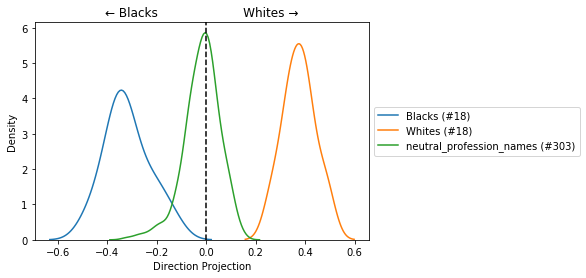

In [54]:
race_bias_we.plot_dist_projections_on_direction({'neutral_profession_names': neutral_profession_names,
                                                 'Whites': group1,
                                                 'Blacks': group2});

In [55]:
race_bias_we.generate_analogies(30)

,x,y,distance,score
0,Greg,Derrick,0.919603,0.644764
1,Sarah,Jasmine,0.941140,0.632409
2,Chris,Cedric,0.966613,0.602972
3,Justin,Darius,0.978899,0.543058
4,Shane,Tyrone,0.994415,0.522137
5,Peter,Andre,0.959946,0.514630
6,Julie,Natasha,0.895858,0.497242
7,Laurie,Wanda,0.918227,0.490559
8,Gary,Leroy,0.974626,0.480240
9,Marc,Dominique,0.960106,0.460851


In [61]:
race_bias_we.generate_analogies(130)[100:]

,x,y,distance,score
100,hockey,basketball,0.879606,0.283794
101,wool,cotton,0.963230,0.283340
102,Comedy_Central,BET,0.983650,0.281611
103,Napoli,Inter_Milan,0.932244,0.281389
104,Wilton,Bethel,0.955348,0.280888
105,Wis.,Ala.,0.995080,0.280833
106,Barrie,Brampton,0.772334,0.280490
107,chocolates,sweets,0.776279,0.279981
108,Pats,Ravens,0.727763,0.279875
109,Australian,Malaysian,0.943748,0.279444


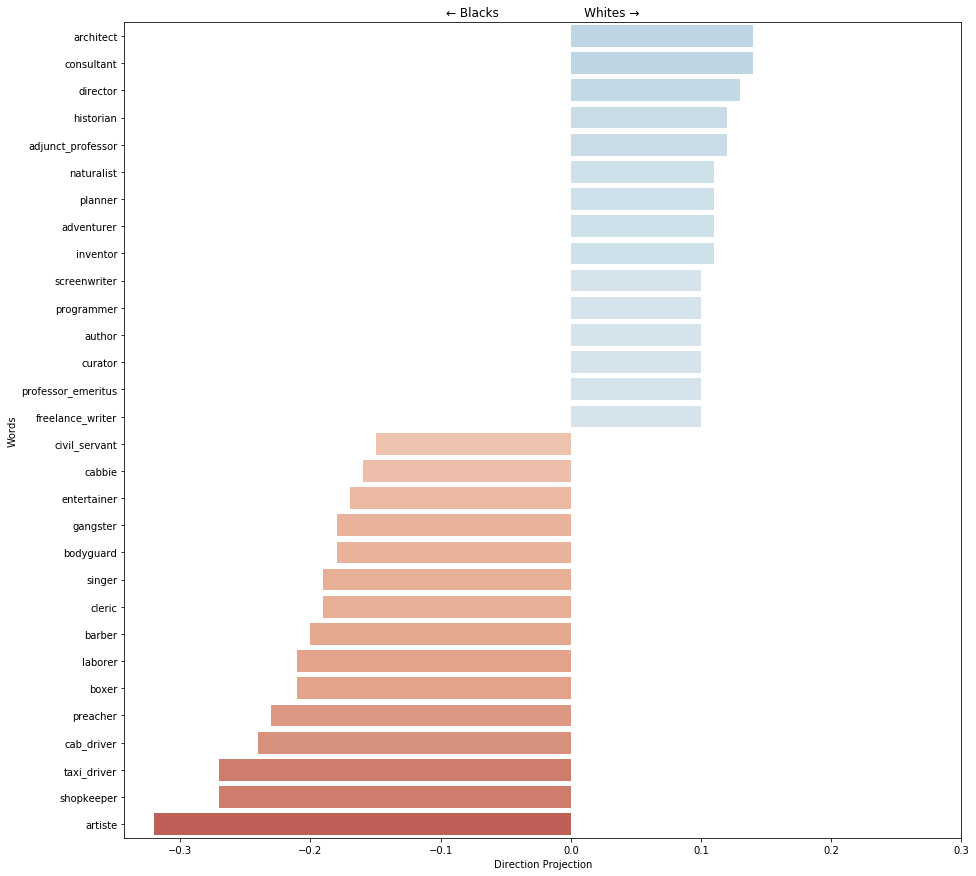

In [62]:
f, ax = plt.subplots(figsize=(15, 15))
race_bias_we.plot_projection_scores(neutral_profession_names, 15, ax=ax);

## Word Embedding Association Test (WEAT)

Based on: Caliskan, A., Bryson, J. J., & Narayanan, A. (2017). [Semantics derived automatically from language corpora contain human-like biases](http://www.cs.bath.ac.uk/~jjb/ftp/CaliskanEtAl-authors-full.pdf). Science, 356(6334), 183-186.

In [63]:
from ethically.we import calc_all_weat

### First, let's look on a reduced version of Word2Vec that is available through `ethically`.

In [64]:
from ethically.we.data import load_w2v_small

model_w2v_small = load_w2v_small()

In [65]:
calc_all_weat(model_w2v_small, filter_by='model', with_original_finding=True,
              with_pvalue=True, pvalue_kwargs={'method': 'approximate'})

,Target words,Attrib. words,Nt,Na,s,d,p,original_N,original_d,original_p
0,Flowers vs. Insects,Pleasant vs. Unpleasant,2x2,24x2,0.0949031,1.23443,1.6e-01,32,1.35,1e-8
1,Instruments vs. Weapons,Pleasant vs. Unpleasant,16x2,24x2,2.11433,1.58925,0,32,1.66,1e-10
2,European American names vs. African American n...,Pleasant vs. Unpleasant,6x2,24x2,0.287312,1.10003,2.6e-02,26,1.17,1e-5
3,European American names vs. African American n...,Pleasant vs. Unpleasant,18x2,24x2,0.952434,1.31962,0,,,
4,European American names vs. African American n...,Pleasant vs. Unpleasant,18x2,8x2,0.538377,0.732444,1.8e-02,,,
5,Male names vs. Female names,Career vs. Family,1x2,8x2,0.247673,2,0,39k,0.72,< 1e-2
6,Math vs. Arts,Male terms vs. Female terms,7x2,8x2,0.184416,0.718851,1.0e-01,28k,0.82,< 1e-2
7,Science vs. Arts,Male terms vs. Female terms,6x2,8x2,0.370207,1.35016,7.0e-03,91,1.47,1e-24
8,Mental disease vs. Physical disease,Temporary vs. Permanent,6x2,5x2,0.590304,1.22442,2.0e-02,135,1.01,1e-3
9,Young people’s names vs. Old people’s names,Pleasant vs. Unpleasant,0x2,7x2,,,,43k,1.42,< 1e-2


### Let's reproduce the results from the paper on the full Word2Vec and Glove words embeddings:

In [66]:
calc_all_weat(glove_model, filter_by='data', with_original_finding=True,
              with_pvalue=True, pvalue_kwargs={'method': 'approximate'})

,Target words,Attrib. words,Nt,Na,s,d,p,original_N,original_d,original_p
0,Flowers vs. Insects,Pleasant vs. Unpleasant,25x2,25x2,3.87,1.50,0,32,1.35,1e-8
1,Instruments vs. Weapons,Pleasant vs. Unpleasant,25x2,25x2,3.85,1.52,0,32,1.66,1e-10
2,European American names vs. African American n...,Pleasant vs. Unpleasant,32x2,25x2,2.92,1.43,0,26,1.17,1e-5
3,European American names vs. African American n...,Pleasant vs. Unpleasant,16x2,25x2,1.30,1.53,0,,,
4,European American names vs. African American n...,Pleasant vs. Unpleasant,16x2,8x2,1.11,1.25,0,,,
5,Male names vs. Female names,Career vs. Family,8x2,8x2,1.80,1.87,0,39k,0.72,< 1e-2
6,Math vs. Arts,Male terms vs. Female terms,8x2,8x2,0.23,1.05,2.2e-02,28k,0.82,< 1e-2
7,Science vs. Arts,Male terms vs. Female terms,8x2,8x2,0.40,1.27,2.0e-03,91,1.47,1e-24
8,Mental disease vs. Physical disease,Temporary vs. Permanent,6x2,7x2,0.90,1.63,0,135,1.01,1e-3
9,Young people’s names vs. Old people’s names,Pleasant vs. Unpleasant,8x2,8x2,0.59,1.45,1.0e-03,43k,1.42,< 1e-2


### Results from the paper:

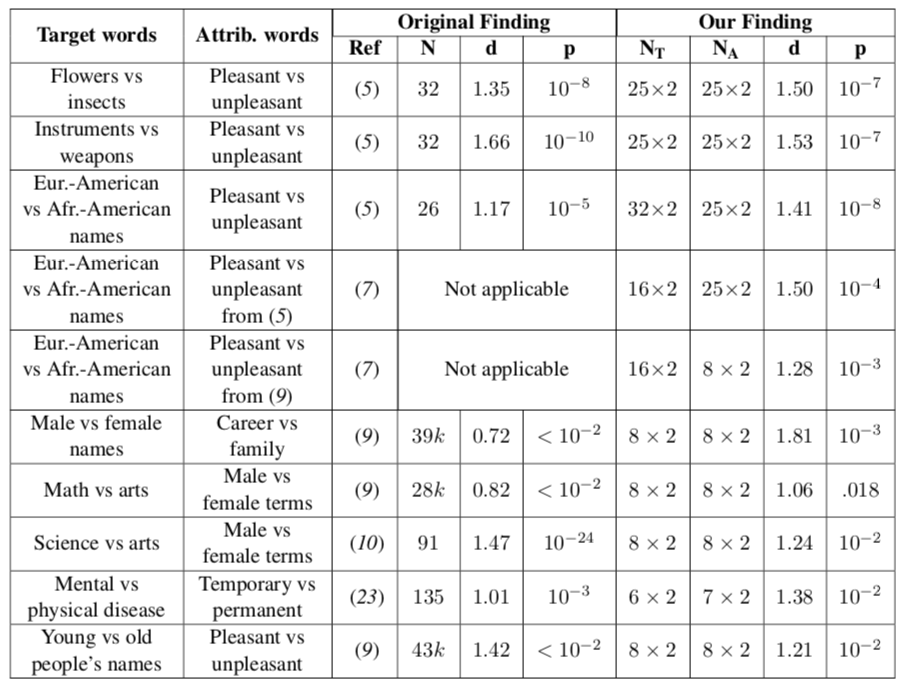

In [67]:
calc_all_weat(w2v_model, filter_by='model', with_original_finding=True,
              with_pvalue=True, pvalue_kwargs={'method': 'approximate'})

,Target words,Attrib. words,Nt,Na,s,d,p,original_N,original_d,original_p
0,Flowers vs. Insects,Pleasant vs. Unpleasant,25x2,25x2,3.23,1.55,0,32,1.35,1e-8
1,Instruments vs. Weapons,Pleasant vs. Unpleasant,24x2,25x2,3.82,1.66,0,32,1.66,1e-10
2,European American names vs. African American n...,Pleasant vs. Unpleasant,47x2,25x2,1.14,0.55,3.0e-03,26,1.17,1e-5
3,European American names vs. African American n...,Pleasant vs. Unpleasant,18x2,25x2,0.86,1.27,0,,,
4,European American names vs. African American n...,Pleasant vs. Unpleasant,18x2,8x2,0.50,0.71,2.0e-02,,,
5,Male names vs. Female names,Career vs. Family,8x2,8x2,2.04,1.93,0,39k,0.72,< 1e-2
6,Math vs. Arts,Male terms vs. Female terms,8x2,8x2,0.27,0.91,3.7e-02,28k,0.82,< 1e-2
7,Science vs. Arts,Male terms vs. Female terms,8x2,8x2,0.44,1.27,2.0e-03,91,1.47,1e-24
8,Mental disease vs. Physical disease,Temporary vs. Permanent,6x2,6x2,0.68,1.45,7.0e-03,135,1.01,1e-3
9,Young people’s names vs. Old people’s names,Pleasant vs. Unpleasant,8x2,7x2,-0.14,-0.38,7.5e-01,43k,1.42,< 1e-2


### Results from the paper:

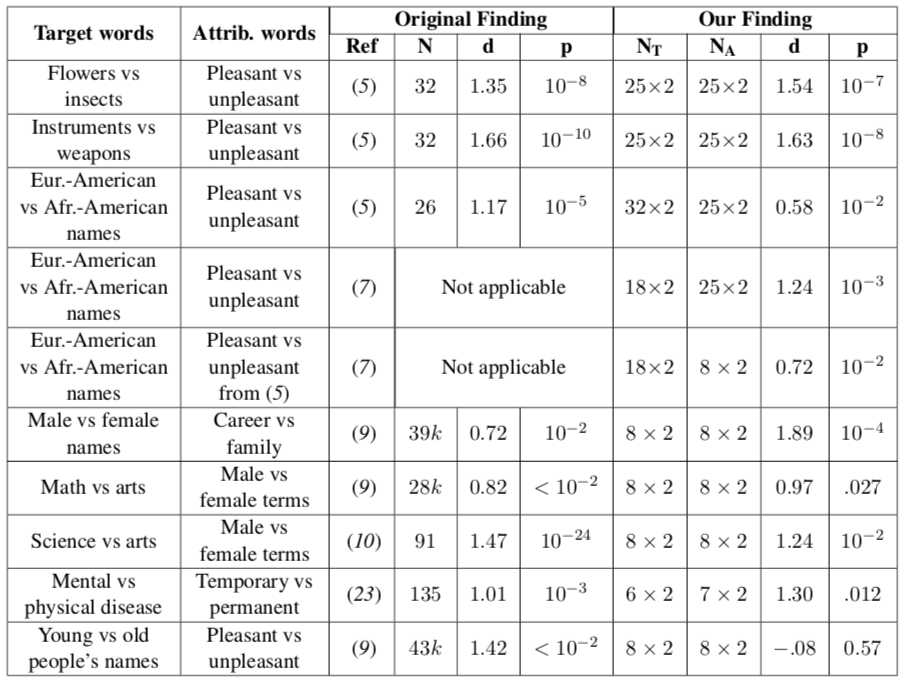

### It is possible also to expirements with new target word sets as in this example (Citizen-Immigrant)

No WEAT bias in this case.

In [68]:
from ethically.we import calc_weat_pleasant_unpleasant_attribute

targets = {'first_target': {'name': 'Citizen',
                            'words': ['citizen', 'citizenship', 'nationality', 'native', 'national', 'countryman', 
                                      'inhabitant', 'resident']},
          'second_target': {'name': 'Immigrant',
                            'words': ['immigrant', 'immigration', 'foreigner', 'nonnative', 'noncitizen',
                                      'relocatee', 'newcomer']}}

calc_weat_pleasant_unpleasant_attribute(w2v_model, **targets)

{'Attrib. words': 'Pleasant vs. Unpleasant',
 'Na': '25x2',
 'Nt': '6x2',
 'Target words': 'Citizen vs. Immigrant',
 'd': 0.71920586,
 'p': 0.135,
 's': 0.23210221529006958}